# TSN Stream Optimization

The overall approach here is to start with each DP in a single stream, and merge the pair of streams that yields the largest reduction in bandwidth usage across the network.  That continues until all merges lead to an increase in bandwidth usage.

### NOTES:

* I assume a single namespace in rt.xml and remove it dynamically when finding elements because namespaces make that hard.  Multiple namespaces will break this code.
* I do not respect port boundaries when merging streams.  That needs to be added, under the assumption that only DPs in an app that belong to the same port can be grouped into a stream.
* I always use the shortest path to send data because there is only one path in the dogbone example.  If there are multiple paths then choosing a path should be part of the algorithm.

### Abdul's notes
* Pay attention to latencies (upper bound) - time in flight
* Realistic scenarios with rate constrained capacity
* Rates can be very odd like 13.2 which is human mixing of DPs, need refresh rates that are more realistic
* Timing requirements = fixed latencies (deterministic, referenced to common time, arrive on time)
* "Chronos induced requirements" - isolation requirements - can't mix apps into the same queue due to hardware on which apps reside (e.g., different assurance levels), how much buffer is available in each switch
* Redundancy - how many copies of the data should the system make to send along different paths to avoid single points of failure numSeamlessTrees; most diverse paths possible

In [1]:
import xml.etree.ElementTree as ET
from math import gcd
from functools import reduce
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import combinations
import random
import matplotlib.pyplot as plt
import re
import os
import subprocess

In [2]:
class DP:
    
    def __init__(self, name, size, rate, port = None):
        self.name = name
        self.size = size
        self.rate = rate
        self.port = port
        
        
    def __str__(self):
        s = 'DP: %s, size = %s, rate = %s' % (self.name, self.size, self.rate)
        if self.port:
            s += ', port = %s' % self.port
        return s

In [3]:
class RP:
    
    def __init__(self, name, source, port = None):
        self.name = name
        self.port = port
        self.source = source
        
        
    def __str__(self):
        s = 'RP: %s, %s' % (self.name, self.source)
        if self.port:
            s += ', port = %s' % self.port
        return s

In [4]:
class Stream:
    
    def __init__(self):
        self.DPs = []
        self.size = None
        self.rate = None
        
        
    def update(self):
        self.size = sum(DP.size for DP in self.DPs) + 50
        rates = [DP.rate for DP in self.DPs]
        self.rate = reduce(gcd, rates)
        
        
    def __str__(self):
        s = ['Stream: size = %d, rate = %d' % (self.size, self.rate), '[']
        for DP in self.DPs:
            s.append('  ' + str(DP))
        s.append(']')
        return '\n'.join(s)

In [5]:
class App:
    
    def __init__(self, name, device):
        self.name = name
        self.device = device
        self.DPs = []
        self.RPs = []
        self.streams = []
        
        
    def add_stream(self, stream):
        stream.update()
        self.streams.append(stream)
        
        
    def remove_stream(self, stream):
        self.streams.remove(stream)
                    
            
    def validate(self):
        DP_names = [DP.name for DP in self.DPs]
        assert len(set(DP_names)) == len(self.DPs), "Duplicate DP names"
        
        if len(self.streams) > 0:
            DP_names = set()
            for stream in self.streams:
                DP_names.update([DP.name for DP in stream.DPs])
            assert len(DP_names) == len(self.DPs), "Mismatch in stream and app DPs"
        
        
    def __str__(self):
        s = []
        s.append('%s on %s' % (self.name, self.device))
        if len(self.streams) > 0:
            for stream in self.streams:
                s.append(str(stream))
        else:
            for DP in self.DPs:
                s.append('  DP: %s, size = %s, rate = %s' % (DP.name, DP.size, DP.rate))
        for RP in self.RPs:
            s.append('  RP: %s, src = %s' % (RP.name, RP.source))
        return '\n'.join(s)

In [6]:
class TSN:
    
    
    def __init__(self):
        self.apps = []
        self.network = None
        self.app_dict = {}
        self.stream_dict = {}
        self.paths = None
        
        
    def add_app(self, app):
        self.apps.append(app)
        self.app_dict[app.name] = app
        
        
    def add_stream(self, app, stream):
        app.add_stream(stream)
        for DP in stream.DPs:
            self.stream_dict['.'.join([app.name, DP.name])] = stream
            
            
    def remove_stream(self, app, stream):
        app.remove_stream(stream)
        for DP in stream.DPs:
            del self.stream_dict['.'.join([app.name, DP.name])]
        
        
    def parse_apps(self, filename):

        xml = ET.parse(filename)
        root = xml.getroot()
        for app in root.findall('Application'):
            app_name = app.get('Name')
            for device in app.findall('DeployedDevice'):
                device_name = device.get('DeviceName')
            application = App(app_name, device_name)
        
            for port in app.findall('Port'):
                port_name = port.get('Name')
            
                for dp in port.findall('DP'):
                    dp_name = dp.get('Name')
                    dp_size = dp.get('ParameterSize')
                    dp_rate = dp.get('transmissionIntervalMinimum')
                    application.DPs.append(DP(dp_name, int(dp_size), int(dp_rate), port = port_name))

                for rp in port.findall('RP'):
                    rp_name = rp.get('Name')
                    for pub_ref in rp.findall('Pub_Ref'):
                        rp_source = pub_ref.get('SrcName')
                    application.RPs.append(RP(rp_name, rp_source, port = port_name))

            self.add_app(application)
            
            
    def parse_topology(self, filename):
        
        with open(filename) as file:
            xmlstring = file.read()
        xmlstring = re.sub(' xmlns="[^"]+"', '', xmlstring, count=1)
        root = ET.fromstring(xmlstring)
        self.network = nx.DiGraph()
                
        for link in root.findall('linkAttributes'):
            from_device = link.find('fromDevicename').text
            to_device = link.find('toDevicename').text
            from_port = link.find('fromPhysicalPortName').text
            to_port = link.find('toPhysicalPortName').text
            link_speed = link.find('linkSpeed').text
            cable_delay = link.find('cableDelay').text

            self.network.add_node(from_device)
            self.network.add_node(to_device)
            self.network.add_edge(from_device, to_device, from_port = from_port,
                                  to_port = to_port, link_speed = float(link_speed),
                                  cable_delay = float(cable_delay))
            
        self.paths = nx.shortest_path(self.network)
            
            
    def singleton_streams(self):
        """
        Make every DP a stream
        """
        
        for app in self.apps:
            for DP in app.DPs:
                s = Stream()
                s.DPs.append(DP)
                self.add_stream(app, s)

            
    def validate(self):
        """
        Sanity checks to ensure that TSN was parsed correctly.
        """
        
        for app in self.apps:
            app.validate()
            
            
    def get_flows(self):
        """
        Return a dictionary keyed on source and destination devices that contains a set of the streams
        that flow between those devices.
        """
        
        flows = defaultdict(lambda: defaultdict(lambda: set()))
        
        for dst_app in self.apps:
            for RP in dst_app.RPs:
                src_app_name, src_dp_name = RP.source.split('.')
                src_device = self.app_dict[src_app_name].device
                dst_device = dst_app.device
                flows[src_device][dst_device].add(self.stream_dict[RP.source])
        
        return flows
    
    
    def get_bandwidth(self, flows, overhead = 50):
        """
        Return a dictionary keyed on source and destination devices that contains the bandwidth
        usage along the link between them given the current streams.
        """
        
        bandwidth = defaultdict(lambda: defaultdict(lambda: float()))
        
        for src_device in flows:
            for dst_device in flows[src_device]:
                for stream in flows[src_device][dst_device]:
                    rate = (stream.size + overhead) / stream.rate
                    path = self.paths[src_device][dst_device]
                    for i in range(len(path) - 1):
                        bandwidth[path[i]][path[i+1]] += rate

        return bandwidth
    
    
    def score_bandwidth(self, bandwidth):
        """
        Return the smallest amount of available bandwidth over all of the links in the TSN.
        Negative numbers mean that the link is overtilized.  Positive numbers mean that there
        is excess capacity.
        """
        
        scores = []
        for src_device in bandwidth:
            for dst_device in bandwidth[src_device]:
                scores.append(self.network[src_device][dst_device]['link_speed'] - bandwidth[src_device][dst_device])
        return min(scores)
    
    
    def write_streams(self, filename):
        s = ['<Stream-Level-ICD>']
             
        stream_id = 1
        
        for app in self.apps:
            if len(app.DPs) == 0:
                continue
            app_num = int(''.join(c for c in app.name if c.isdigit()))

            s.append('  <Application Name="%s">' % app.name)
            s.append('  <DeployedDevice DeviceName="%s"/>' % app.device)
            s.append('  <Port Name="%s"/>' % app.DPs[0].port)
            
            for stream_num, stream in enumerate(app.streams):
                s.append('    <Stream Name="Stream%d-%d" ID="%d" FramesPerPeriod="1" MaxFrameSize="%d" RefreshPeriod="%d">' %
                         (app_num, stream_num, stream_id, stream.size, stream.rate))
                
                for DP in stream.DPs:
                    s.append('      <DP Name="%s" ParameterSize="%s" transmissionIntervalMinimum="%s"/>' %
                             (DP.name, DP.size, DP.rate))

                s.append('    </Stream>')
                stream_id += 1
                
            s.append('  </Application>')
             
        s.append('</Stream-Level-ICD>')
    

        with open(filename, 'w') as file:
            file.write('\n'.join(s))


In [7]:
def eval_merges(tsn):
    """
    Loop over all apps, and within an app loop over all pairs of streams.  Compute the
    bandwidth score if that pair of streams is merged.  Return a list of lists of the form
    [app, stream1, stream2, score] sorted from highest (best) score to lowest (worst) score.
    """
    
    merges = []
    
    for app in tsn.apps:
        for s1, s2 in combinations(app.streams, 2):
            tsn.remove_stream(app, s1)
            tsn.remove_stream(app, s2)
            s = Stream()
            s.DPs = s1.DPs + s2.DPs
            tsn.add_stream(app, s)

            flows = tsn.get_flows()
            bandwidth = tsn.get_bandwidth(flows)
            score = tsn.score_bandwidth(bandwidth)
    
            merges.append([app, s1, s2, score])
        
            tsn.remove_stream(app, s)
            tsn.add_stream(app, s1)
            tsn.add_stream(app, s2)

    random.shuffle(merges)
    merges.sort(key = lambda x: x[3], reverse = True)
    
    return merges

In [8]:
PARAMETER_FILE = 'Parameter_Level_ICD.xml'
RT_FILE = 'rt.xml'
STREAM_FILE = 'Streams.xml'
SHARED_DATA_DIR = 'shared_data'

In [9]:
def create_chronos_project(tsn, path):
    if not os.path.exists(path):
        os.makedirs(path)
        
    tsn.write_streams(os.path.join(path, STREAM_FILE))
    os.system('python StreamConvertor.py %s %s' % (RT_FILE, STREAM_FILE))
    os.system('cp %s %s' % (RT_FILE, path))
    os.system('cp Qcc.xml %s' % path)

    with open('project_template.xml') as file:
        project = file.read()
    project = project.replace('RT_FILE', RT_FILE)
    with open('%s/project.xml' % path, 'w') as file:
        file.write(project)    

In [10]:
def run_chronos(project_dir):
    cmd = ['VBoxManage', 'guestcontrol', 'chronos', '--username', 'oates', '--password',
           'Hunt2121!', 'run', '--exe', 'C:\Program Files\GE Research\Chronos_CLI\\application\Chronos_CLI.exe',
           '--', 'Z:\%s\project.xml' % project_dir]
    subprocess.call(cmd)
    return open(os.path.join(SHARED_DATA_DIR, project_dir, 'out_cli', 'scenario_summary.json')).read()

In [11]:
def optimize_tsn(tsn, write_project = False, chronos_runs = []):
    """
    Greedily merge streams in a TSN until no merge reduces bandwidth utilization.
    """
    
    scores = []
    
    tsn.singleton_streams()
    flows = tsn.get_flows()
    bandwidth = tsn.get_bandwidth(flows)
    score = tsn.score_bandwidth(bandwidth)
    print('Initial score = %.2f' % score)
    scores.append(score)
    
    idx = 0
    while True:
        idx += 1
        if write_project:
            create_chronos_project(tsn, os.path.join(SHARED_DATA_DIR, 'tsn_%d' % idx))
            
        merges = eval_merges(tsn)
        app, s1, s2, new_score = merges[0]
        if new_score <= score:
            break
            
        print('New score = %8.2f' % new_score)
        print('%s on %s' % (app.name, app.device))
        print(s1)
        print(s2)
        print('\n\n')
        
        if write_project and idx in chronos_runs:
            print('Chronos output: %s' % run_chronos('tsn_%d' % idx))
        
        score = new_score
        scores.append(score)
        tsn.remove_stream(app, s1)
        tsn.remove_stream(app, s2)
        s = Stream()
        s.DPs = s1.DPs + s2.DPs
        tsn.add_stream(app, s)
                
    return scores

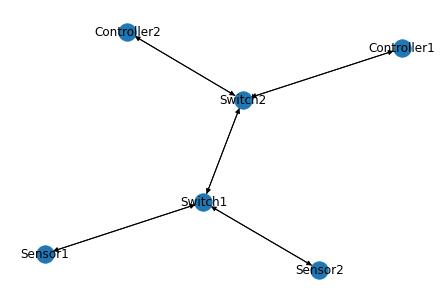

In [12]:
tsn = TSN()
tsn.parse_apps(PARAMETER_FILE)
tsn.parse_topology(RT_FILE)
tsn.validate()
nx.draw(tsn.network, with_labels = True)
plt.show()

In [14]:
print('%d apps' % len(tsn.apps))
print('%d DPs' % sum(len(app.DPs) for app in tsn.apps))

70 apps
184 DPs


In [13]:
scores = optimize_tsn(tsn, write_project = True, chronos_runs = list(range(1, 500, 5)))

Initial score = -842.01
New score =  -822.01
TSNApp14 on Sensor2
Stream: size = 52, rate = 10
[
  DP: DP120, size = 2, rate = 10, port = eth0
]
Stream: size = 54, rate = 10
[
  DP: DP126, size = 4, rate = 10, port = eth0
]



Chronos output: {"valid":true,"feasible":true,"stream1":"00-0a-35-00-01-10:17-70","stream2":"00-0a-35-00-01-10:17-71","stream3":"00-0a-35-00-01-10:17-72","stream4":"00-0a-35-00-01-10:17-73","stream5":"00-0a-35-00-01-10:17-74","num_unscheduled_streams":0}

New score =  -802.01
TSNApp6 on Sensor2
Stream: size = 52, rate = 10
[
  DP: DP48, size = 2, rate = 10, port = eth0
]
Stream: size = 66, rate = 10
[
  DP: DP50, size = 16, rate = 10, port = eth0
]



New score =  -782.01
TSNApp1 on Sensor1
Stream: size = 54, rate = 10
[
  DP: DP3, size = 4, rate = 10, port = eth0
]
Stream: size = 51, rate = 10
[
  DP: DP7, size = 1, rate = 10, port = eth0
]



New score =  -762.01
TSNApp3 on Sensor1
Stream: size = 51, rate = 10
[
  DP: DP18, size = 1, rate = 10, port = eth0
]
Str

Chronos output: {"valid":true,"feasible":true,"stream1":"00-0a-35-00-01-10:17-70","stream2":"00-0a-35-00-01-10:17-71","stream3":"00-0a-35-00-01-10:17-72","stream4":"00-0a-35-00-01-10:17-73","stream5":"00-0a-35-00-01-10:17-74","num_unscheduled_streams":0}

New score =  -392.01
TSNApp7 on Sensor1
Stream: size = 58, rate = 20
[
  DP: DP63, size = 8, rate = 20, port = eth0
]
Stream: size = 54, rate = 20
[
  DP: DP64, size = 4, rate = 20, port = eth0
]



New score =  -382.01
TSNApp7 on Sensor1
Stream: size = 52, rate = 20
[
  DP: DP57, size = 2, rate = 20, port = eth0
]
Stream: size = 66, rate = 20
[
  DP: DP58, size = 16, rate = 20, port = eth0
]



New score =  -372.01
TSNApp2 on Sensor2
Stream: size = 54, rate = 20
[
  DP: DP11, size = 4, rate = 20, port = eth0
]
Stream: size = 66, rate = 20
[
  DP: DP13, size = 16, rate = 20, port = eth0
]



New score =  -362.01
TSNApp8 on Sensor2
Stream: size = 51, rate = 20
[
  DP: DP73, size = 1, rate = 20, port = eth0
]
Stream: size = 58, rate = 2

New score =  -132.01
TSNApp10 on Sensor2
Stream: size = 51, rate = 20
[
  DP: DP88, size = 1, rate = 20, port = eth0
]
Stream: size = 52, rate = 20
[
  DP: DP89, size = 2, rate = 20, port = eth0
]



New score =  -122.01
TSNApp6 on Sensor2
Stream: size = 52, rate = 20
[
  DP: DP45, size = 2, rate = 20, port = eth0
]
Stream: size = 62, rate = 20
[
  DP: DP46, size = 2, rate = 20, port = eth0
  DP: DP49, size = 2, rate = 20, port = eth0
  DP: DP53, size = 8, rate = 20, port = eth0
]



New score =  -112.01
TSNApp18 on Sensor2
Stream: size = 56, rate = 20
[
  DP: DP155, size = 2, rate = 20, port = eth0
  DP: DP158, size = 4, rate = 20, port = eth0
]
Stream: size = 56, rate = 20
[
  DP: DP160, size = 4, rate = 20, port = eth0
  DP: DP161, size = 2, rate = 20, port = eth0
]



New score =  -102.21
TSNApp14 on Sensor2
Stream: size = 52, rate = 20
[
  DP: DP121, size = 2, rate = 20, port = eth0
]
Stream: size = 56, rate = 10
[
  DP: DP120, size = 2, rate = 10, port = eth0
  DP: DP126, size = 

New score =    68.39
TSNApp6 on Sensor2
Stream: size = 52, rate = 30
[
  DP: DP51, size = 2, rate = 30, port = eth0
]
Stream: size = 62, rate = 30
[
  DP: DP47, size = 4, rate = 30, port = eth0
  DP: DP52, size = 8, rate = 30, port = eth0
]



New score =    75.05
TSNApp8 on Sensor2
Stream: size = 54, rate = 30
[
  DP: DP69, size = 4, rate = 30, port = eth0
]
Stream: size = 58, rate = 30
[
  DP: DP67, size = 4, rate = 30, port = eth0
  DP: DP70, size = 4, rate = 30, port = eth0
]



New score =    81.72
TSNApp16 on Sensor2
Stream: size = 52, rate = 30
[
  DP: DP140, size = 2, rate = 30, port = eth0
]
Stream: size = 54, rate = 30
[
  DP: DP145, size = 4, rate = 30, port = eth0
]



New score =    88.39
TSNApp12 on Sensor2
Stream: size = 58, rate = 30
[
  DP: DP106, size = 8, rate = 30, port = eth0
]
Stream: size = 52, rate = 30
[
  DP: DP109, size = 2, rate = 30, port = eth0
]



New score =    95.05
TSNApp20 on Sensor2
Stream: size = 54, rate = 30
[
  DP: DP176, size = 4, rate = 30, po

Chronos output: {"valid":true,"feasible":true,"stream1":"00-0a-35-00-01-10:17-70","stream2":"00-0a-35-00-01-10:17-71","stream3":"00-0a-35-00-01-10:17-72","stream4":"00-0a-35-00-01-10:17-73","stream5":"00-0a-35-00-01-10:17-74","num_unscheduled_streams":0}

New score =   268.12
TSNApp10 on Sensor2
Stream: size = 52, rate = 30
[
  DP: DP87, size = 2, rate = 30, port = eth0
]
Stream: size = 57, rate = 10
[
  DP: DP85, size = 4, rate = 10, port = eth0
  DP: DP88, size = 1, rate = 20, port = eth0
  DP: DP89, size = 2, rate = 20, port = eth0
]



New score =   274.52
TSNApp13 on Sensor1
Stream: size = 52, rate = 30
[
  DP: DP115, size = 2, rate = 30, port = eth0
]
Stream: size = 58, rate = 10
[
  DP: DP116, size = 4, rate = 20, port = eth0
  DP: DP118, size = 2, rate = 10, port = eth0
  DP: DP119, size = 2, rate = 10, port = eth0
]



New score =   280.92
TSNApp3 on Sensor1
Stream: size = 52, rate = 30
[
  DP: DP27, size = 2, rate = 30, port = eth0
]
Stream: size = 74, rate = 10
[
  DP: DP18,

New score =   389.39
TSNApp7 on Sensor1
Stream: size = 82, rate = 10
[
  DP: DP56, size = 1, rate = 10, port = eth0
  DP: DP63, size = 8, rate = 20, port = eth0
  DP: DP64, size = 4, rate = 20, port = eth0
  DP: DP59, size = 1, rate = 20, port = eth0
  DP: DP57, size = 2, rate = 20, port = eth0
  DP: DP58, size = 16, rate = 20, port = eth0
]
Stream: size = 64, rate = 30
[
  DP: DP55, size = 2, rate = 30, port = eth0
  DP: DP61, size = 8, rate = 30, port = eth0
  DP: DP62, size = 4, rate = 30, port = eth0
]



New score =   394.19
TSNApp6 on Sensor2
Stream: size = 82, rate = 10
[
  DP: DP48, size = 2, rate = 10, port = eth0
  DP: DP50, size = 16, rate = 10, port = eth0
  DP: DP45, size = 2, rate = 20, port = eth0
  DP: DP46, size = 2, rate = 20, port = eth0
  DP: DP49, size = 2, rate = 20, port = eth0
  DP: DP53, size = 8, rate = 20, port = eth0
]
Stream: size = 64, rate = 30
[
  DP: DP51, size = 2, rate = 30, port = eth0
  DP: DP47, size = 4, rate = 30, port = eth0
  DP: DP52, size = 8

New score =   458.11
TSNApp11 on Sensor1
Stream: size = 58, rate = 40
[
  DP: DP102, size = 8, rate = 40, port = eth0
]
Stream: size = 83, rate = 10
[
  DP: DP99, size = 4, rate = 10, port = eth0
  DP: DP93, size = 4, rate = 10, port = eth0
  DP: DP101, size = 8, rate = 10, port = eth0
  DP: DP96, size = 1, rate = 20, port = eth0
  DP: DP100, size = 2, rate = 20, port = eth0
  DP: DP92, size = 4, rate = 30, port = eth0
  DP: DP94, size = 2, rate = 30, port = eth0
  DP: DP95, size = 4, rate = 30, port = eth0
  DP: DP98, size = 4, rate = 30, port = eth0
]



Chronos output: {"valid":true,"feasible":true,"stream1":"00-0a-35-00-01-10:17-70","stream2":"00-0a-35-00-01-10:17-71","stream3":"00-0a-35-00-01-10:17-72","stream4":"00-0a-35-00-01-10:17-73","stream5":"00-0a-35-00-01-10:17-74","num_unscheduled_streams":0}

New score =   461.91
TSNApp10 on Sensor2
Stream: size = 59, rate = 10
[
  DP: DP87, size = 2, rate = 30, port = eth0
  DP: DP85, size = 4, rate = 10, port = eth0
  DP: DP88, size = 

In [14]:
for app in tsn.apps:
    print(app)

TSNApp1 on Sensor1
Stream: size = 106, rate = 10
[
  DP: DP0, size = 4, rate = 30, port = eth0
  DP: DP9, size = 16, rate = 30, port = eth0
  DP: DP8, size = 4, rate = 40, port = eth0
  DP: DP6, size = 4, rate = 10, port = eth0
  DP: DP10, size = 4, rate = 10, port = eth0
  DP: DP3, size = 4, rate = 10, port = eth0
  DP: DP7, size = 1, rate = 10, port = eth0
  DP: DP5, size = 8, rate = 20, port = eth0
  DP: DP2, size = 8, rate = 20, port = eth0
  DP: DP1, size = 1, rate = 20, port = eth0
  DP: DP4, size = 2, rate = 20, port = eth0
]
TSNApp2 on Sensor2
Stream: size = 91, rate = 10
[
  DP: DP12, size = 4, rate = 30, port = eth0
  DP: DP14, size = 8, rate = 10, port = eth0
  DP: DP17, size = 1, rate = 10, port = eth0
  DP: DP11, size = 4, rate = 20, port = eth0
  DP: DP13, size = 16, rate = 20, port = eth0
  DP: DP15, size = 4, rate = 50, port = eth0
  DP: DP16, size = 4, rate = 50, port = eth0
]
TSNApp3 on Sensor1
Stream: size = 86, rate = 10
[
  DP: DP27, size = 2, rate = 30, port = eth

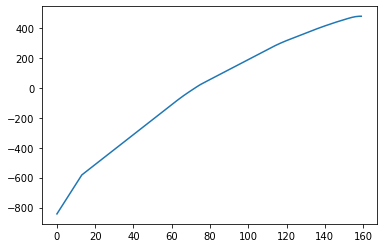

In [15]:
plt.plot(scores)